# EDA, Data Visualization, and Feature Engineering

In [1]:
# !bash push.sh

## IMPORTS

In [2]:
import requests
import pandas                        as pd
import numpy                         as np

import seaborn                       as sns
import matplotlib.pyplot             as plt
from wordcloud                       import WordCloud, STOPWORDS 

from googletrans                     import Translator
translator = Translator()
from spellchecker                    import SpellChecker
spellcheck = SpellChecker()

import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.tokenize                   import TweetTokenizer
from nltk.corpus                     import stopwords
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cvec = CountVectorizer()
import re
tokenizer = TweetTokenizer(preserve_case = True, strip_handles = True)

import time
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [3]:
eng_train = pd.read_csv('Data/trac2_eng_train.csv')
eng_train.sample(5)

,ID,Text,Sub-task A,Sub-task B
3863,C7.2539,Only because of you I started watching regiona...,NAG,NGEN
64,C4.1321.3,Totally agree with ur points bro nd kabir sing...,OAG,NGEN
3008,C4.1684,Man i serioulsy want this guy to blow up so th...,NAG,NGEN
338,C7.495,Kabir Singh my favourite 🔼🔼,NAG,NGEN
3147,C4.574,the kind of cinema satyajit ray visioned is ne...,CAG,NGEN


In [4]:
classes = ['NAG', 'CAG', 'OAG'] # Dependant variable

### Null / Duplicate Entries

In [5]:
eng_train.info() # no null enteries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4263 entries, 0 to 4262
Data columns (total 4 columns):
ID            4263 non-null object
Text          4263 non-null object
Sub-task A    4263 non-null object
Sub-task B    4263 non-null object
dtypes: object(4)
memory usage: 133.3+ KB


In [6]:
set(eng_train.duplicated().tolist()) # no duplicates

{False}

### Class Balance

In [7]:
def barplot(df, x, y, title, label, ylabel, dim, orient = "v", ci = False, hue = None):
    
    plt.figure(figsize = dim, facecolor = "white")
    sns.barplot(x = x, y = y, data = df, orient = orient, ci = ci, hue = hue)
    plt.title(f"{title}", size = 18)
    plt.xlabel(f"{label}", size = 16)
    plt.ylabel(f"{ylabel}", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.tight_layout();

NAG    3375
CAG     453
OAG     435
Name: Sub-task A, dtype: int64

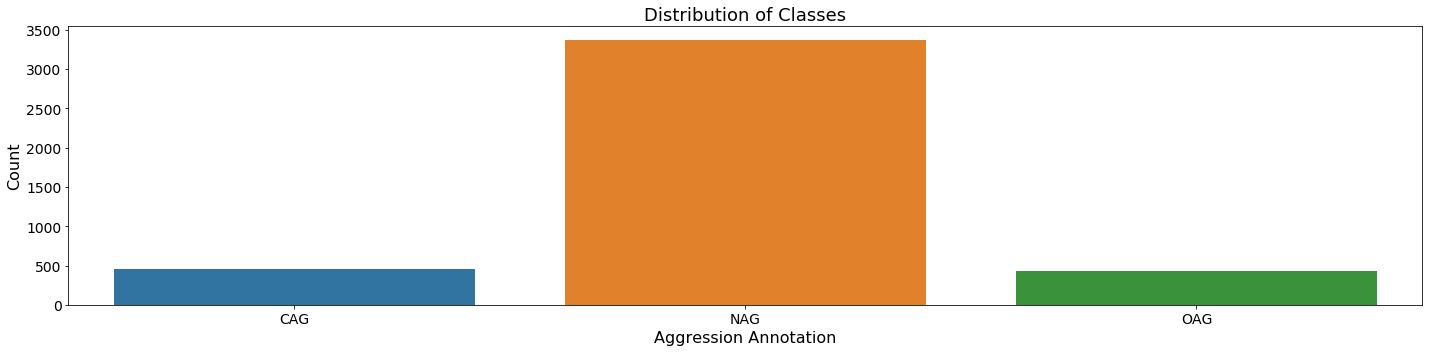

In [8]:
taskA_df = (eng_train.set_index(['ID', 'Sub-task A']).count(level='Sub-task A'))

barplot(df = taskA_df,
        x = taskA_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Aggression Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task A'].value_counts()

NGEN    3954
GEN      309
Name: Sub-task B, dtype: int64

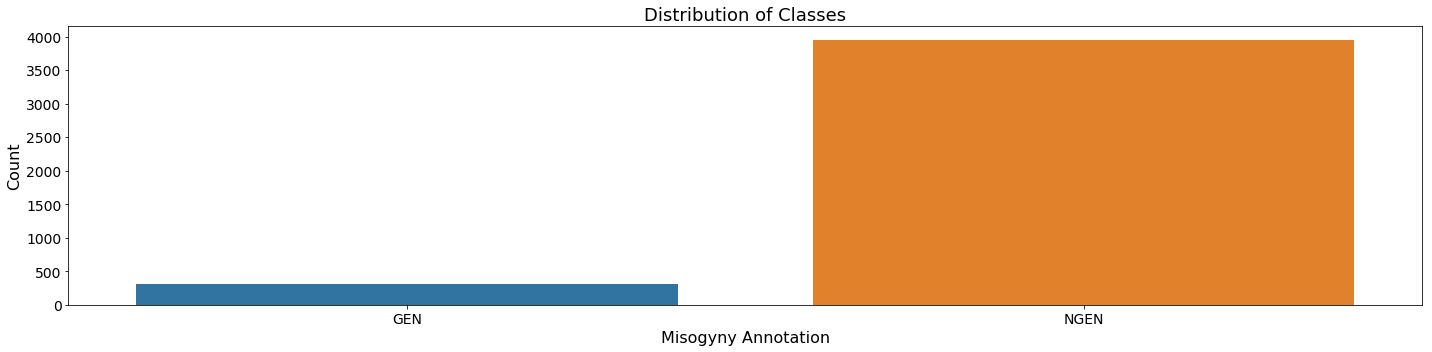

In [9]:
taskB_df = (eng_train.set_index(['ID', 'Sub-task B']).count(level='Sub-task B'))

barplot(df = taskB_df,
        x = taskB_df.index,
        y = "Text",
        title = "Distribution of Classes",
        label = "Misogyny Annotation",
        ylabel = "Count",
        dim = (20, 5))

eng_train['Sub-task B'].value_counts()

## DATA CLEANING & NORMALIZATION

### Part-of-Speech Distribution

In [10]:
def POS(df, attribute):
    total_tokens = []
    freq = {}
    for text in df[attribute]:
        doc = nlp(text)
        tokens = []
        for word in doc:
            pos = word.pos_
            if (pos in freq): 
                freq[pos] += 1
            else: 
                freq[pos] = 1
            tokens.append(pos)

        total_tokens.append(tokens)
    pos_df = pd.DataFrame({'POS': list(freq.keys()), 'Frequency':list(freq.values())})
    return pos_df

      POS  Frequency
0     ADJ       6094
1    NOUN      17789
2   SPACE       4237
3       X        714
4   PROPN       5613
5    PRON       5948
6   PUNCT       8710
7    VERB      14942
8    PART       1319
9     ADP       7175
10    DET       7297
11  CCONJ       2453
12    ADV       5643
13   INTJ        733
14    AUX        159
15    NUM        832
16    SYM        273

Part-of-speech tagging counts for combined corpus


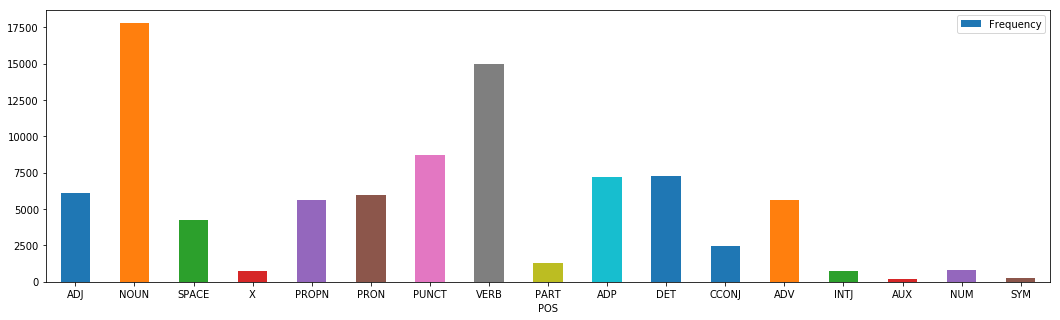

In [11]:
pos_df = POS(eng_train, 'Text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### List of transliterated proper nouns (PROPN) in the corpus

In [12]:
def transliteration_list(df):
    propn = []
    for text in df['Text']:
        doc = nlp(text)
        for word in doc:
            pos = word.pos_
            if (pos == 'PROPN'): 
                propn.append(word.text)
            else: 
                continue
    return propn

In [13]:
propn = transliteration_list(eng_train)

### Stopwords

In [14]:
def fetch_stopwords(url):
    stop = pd.read_csv(url, sep='\n', header=0, names=['words'])
    stop = stop['words'].values.tolist()
    return stop

In [15]:
# from stopwordsiso import stopwords
# bangla_stopwords = stopwords('bn')

hinglish_stopwords = fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hinglish')
english_stopwords = set(stopwords.words('english') + hinglish_stopwords)
hindi_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/TrigonaMinima/HinglishNLP/master/data/assets/stop_hindi'))
bangla_stopwords = set(fetch_stopwords('https://raw.githubusercontent.com/rachitsaksena/Multilingual-Agression-Classification/master/bangla%20stop.txt'))

In [16]:
stop_dict = {'en': english_stopwords,
             'hi': hindi_stopwords,
             'bn': bangla_stopwords}

### Emoji and Special Character Removal

In [17]:
def deEmojify(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F923"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [18]:
def clean_text(df, lang):
    stop_words = stop_dict[lang]
    df['clean text'] = df['Text']
    for i in range(df.shape[0]):
        sentence = df['Text'].iloc[i]
        sentence = deEmojify(sentence)
        sentence = re.sub(r"([.!?])", r"\1 ", sentence)
        sentence = re.sub(r'[/(){}\[\]\|@,;:.]', r'', str(sentence))
#         sentence = re.sub(r"[^a-z]+", r" ", sentence)
        sentence = ' '.join(word.lower() for word in sentence.split() if word not in stop_words and len(word)>2)
        df['clean text'].iloc[i] = sentence
    df['tokenized'] = [tokenizer.tokenize(text) for text in df['clean text']]
    return df

In [19]:
clean_text(eng_train, 'en')
eng_train.head()

,ID,Text,Sub-task A,Sub-task B,clean text,tokenized
0,C45.451,Next part,NAG,NGEN,next part,"[next, part]"
1,C47.11,Iii8mllllllm\nMdxfvb8o90lplppi0005,NAG,NGEN,iii8mllllllm mdxfvb8o90lplppi0005,"[iii, 8mllllllm, mdxfvb, 8o90lplppi0005]"
2,C33.79,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,NAG,NGEN,osm vedio make vedios,"[osm, vedio, make, vedios]"
3,C4.1961,What the fuck was this? I respect shwetabh and...,NAG,NGEN,what fuck this? respect shwetabh watching vide...,"[what, fuck, this, ?, respect, shwetabh, watch..."
4,C10.153,Concerned authorities should bring arundathi R...,NAG,NGEN,concerned authorities bring arundathi roy type...,"[concerned, authorities, bring, arundathi, roy..."


      POS  Frequency
0     ADJ       5835
1    NOUN      18506
2     ADP        376
3    VERB       6735
4    PRON        755
5     DET        692
6   PUNCT       1329
7    INTJ        340
8   CCONJ        262
9     ADV       1670
10   PART        189
11    NUM        363
12      X        284
13    AUX         33
14    SYM         56
15  PROPN        181

Part-of-speech tagging counts for combined corpus


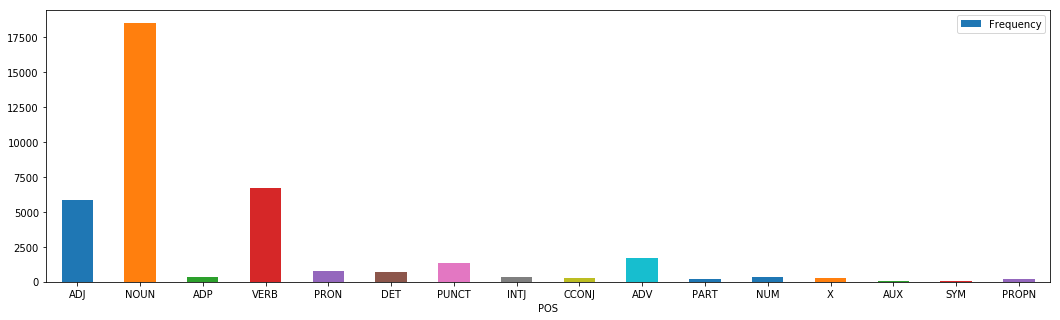

In [20]:
pos_df = POS(eng_train, 'clean text')
print(pos_df)
print('\nPart-of-speech tagging counts for combined corpus')
pos_df.plot.bar(x ='POS', y ='Frequency', rot = 0, figsize=(18,5))

### Lexicon Normalization

In [21]:
def script_tag(text):
    ben = re.compile("[" u"\U00000980-\U000009FF" "]+", flags=re.UNICODE) # Bengali
    hin = re.compile("[" u"\U00000900-\U0000097F" "]+", flags=re.UNICODE) # Hindi

    if ben.match(text):
        return 'bn'
    elif hin.match(text):
        return 'hi'
    else:
        return 'en'

In [22]:
def language_tag(df):
    df['normalized lexicon'] = df['clean text']
    for i in range(df.shape[0]):
        lis = []
        words = df['tokenized'].loc[i]
        for word in words:
            script = script_tag(word) 
            trans_script = translator.translate(word).src
            if(script == 'hi' or trans_script == 'hi'):
                lis.append(translator.translate(word, src='hi').text.lower())
            elif(script == 'bn' or trans_script == 'bn'):
                lis.append(translator.translate(word, src='bn').text.lower())
            elif(script == 'en' or trans_script == 'en'):
                if word in propn: #PROPN
                    lis.append(word.lower())
                if len(spellcheck.unknown([word]))!=0: #SPELL CHECK
                    lis.append(spellcheck.correction(word).lower())
                else:
                    lis.append(word.lower())
        df['normalized lexicon'].loc[i] = lis
    return df

In [ ]:
language_tag(eng_train)  # Takes considerable amount of time to run

In [ ]:
def normalized_lex_string(lis):
    return ' '.join(word for word in lis)

In [ ]:
eng_train['monolingual'] = eng_tain['normalized lexicon'].apply(lambda x : normalized_lex_string(x))

In [ ]:
eng_train.sample(5)

### Class Interdependence

In [ ]:
# WORD CLOUD
for agg in classes:
    words = ''
    stopwords = set(STOPWORDS)

    for val in eng_train[eng_train["Sub-task A"] == agg]['monolingual']: 
        tokens = str(val).split() 
        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, 
                          height = 800, 
                          background_color ='white', 
                          stopwords = stopwords, 
                          min_font_size = 10).generate(words) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    print(agg)
    plt.show() 
    print("\n\n\n")

In [ ]:
# MOST FREQUENT STATS

def plot_most_frequent_words(df, agg):
    cnt = 0
    fig = plt.figure(figsize = (24, 20), facecolor = "white")   
    cnt += 1
    ax = fig.add_subplot(2, 2, cnt)

    sns.barplot(x = 0, y = df['Sub-task A'], data = df, palette = "deep")

    plt.title(f"Most Common Words from {agg} class are", size = 20)
    plt.xlabel("Frequency", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

In [ ]:
sns.set(style = "white", palette = "deep")

for agg in classes:
    subset = eng_train[eng_train["Sub-task A"] == agg]
    vecs = cvec.fit_transform(subset["monolingual"])
    vectorized_df = pd.DataFrame(vecs.toarray(), columns = cvec.get_feature_names())

    # Getting the 20 most frequent words from each
    frequent = pd.DataFrame(vectorized_df.sum().sort_values(ascending = False).head(20))
    
    plot_most_frequent_words(df = frequent, agg = agg)

In [ ]:
# CLEANING